In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import tqdm
import os
import gc
import glob
import math
import torch
import utils
from scipy.special import erf
from sklearn.calibration import calibration_curve
from sklearn.metrics import (auc, brier_score_loss, confusion_matrix,
                             mean_absolute_error, mean_squared_error,
                             precision_recall_curve, r2_score, roc_curve,
							 precision_score, recall_score, f1_score,
                             mutual_info_score)
from sklearn.feature_selection import mutual_info_regression, r_regression
from scipy.stats import entropy
import utils

/home/mcoughlan/anaconda3/envs/pytorch/lib/python3.11/site-packages/spacepy/time.py:2367: UserWarning: Leapseconds may be out of date. Use spacepy.toolbox.update(leapsecs=True)
  warnings.warn('Leapseconds may be out of date.'


In [2]:
model_type = 'twins'
shap_dir = 'outputs/shap_values'
scaler_dir = 'outputs/scalers'
results_dir = 'outputs/rsd'
VERSION = 'swmag_v6-1'
shap_files = glob.glob(f'{shap_dir}/*{VERSION}*.pkl')
scaler_files = glob.glob(f'{scaler_dir}/*{VERSION}.pkl')
results_files = glob.glob(f'{scaler_dir}/*{VERSION}.feather')
with open('cluster_dict.pkl', 'rb') as f:
	cluster_dict = pickle.load(f)

list_of_oversampled_regions = ['GRL-1', 'GRL-2', 'JPN-0', 'JPN-1', 'SVLB']

In [3]:
scalers = {}
for cluster in cluster_dict.values():
	for key, region in cluster['regions'].items():
		scalers[key] = {}
		if key in list_of_oversampled_regions:
			# if os.path.exists(f'{scaler_dir}/twins_{key}_twins_v_dbht_maxpooling_oversampling.pkl') and \
			# 	os.path.exists(f'{scaler_dir}/twins_{key}_twins_alt_method_v2_maxpooling_oversampling.pkl'):
			# 	print('hello world')
			with open(f'{scaler_dir}/twins_{key}_twins_v_dbht_maxpooling_oversampling.pkl', 'rb') as f:
				scaler_values = pickle.load(f)
				scalers[key]['dbht'] = scaler_values
			with open(f'{scaler_dir}/twins_{key}_twins_alt_method_v2_maxpooling_oversampling.pkl', 'rb') as f:
				scaler_values = pickle.load(f)
				scalers[key]['rsd'] = scaler_values
		else:
			# if os.path.exists(f'{scaler_dir}/twins_{key}_twins_v_dbht_maxpooling.pkl') and \
			# 	os.path.exists(f'{scaler_dir}/twins_{key}_twins_alt_method_v2_maxpooling.pkl'):
			with open(f'{scaler_dir}/twins_{key}_twins_v_dbht_maxpooling.pkl', 'rb') as f:
				scaler_values = pickle.load(f)
				scalers[key]['dbht'] = scaler_values
			with open(f'{scaler_dir}/twins_{key}_twins_alt_method_v2_maxpooling.pkl', 'rb') as f:
				scaler_values = pickle.load(f)
				scalers[key]['rsd'] = scaler_values

In [4]:
for cluster in cluster_dict.values():
	for key, region in cluster['regions'].items():
		if key in list_of_oversampled_regions:
			if os.path.exists(f'{shap_dir}/twins_region_{key}_twins_v_dbht_maxpooling_oversampling.pkl') and \
				os.path.exists(f'{shap_dir}/twins_region_{key}_twins_alt_method_v2_maxpooling_oversampling.pkl'):
				with open(f'{shap_dir}/twins_region_{key}_twins_v_dbht_maxpooling_oversampling.pkl', 'rb') as f:
					shap_values = pickle.load(f)
					cluster['regions'][key]['dbht'] = shap_values
					print(f'finished {key} dbht')
				with open(f'{shap_dir}/twins_region_{key}_twins_alt_method_v2_maxpooling_oversampling.pkl', 'rb') as f:
					shap_values = pickle.load(f)
					cluster['regions'][key]['rsd'] = shap_values
					print(f'finished {key} rsd')
		else:
			if os.path.exists(f'{shap_dir}/twins_region_{key}_twins_v_dbht_maxpooling.pkl') and \
				os.path.exists(f'{shap_dir}/twins_region_{key}_twins_alt_method_v2_maxpooling.pkl'):
				with open(f'{shap_dir}/twins_region_{key}_twins_v_dbht_maxpooling.pkl', 'rb') as f:
					shap_values = pickle.load(f)
					cluster['regions'][key]['dbht'] = shap_values
					print(f'finished {key} dbht')
				with open(f'{shap_dir}/twins_region_{key}_twins_alt_method_v2_maxpooling.pkl', 'rb') as f:
					shap_values = pickle.load(f)
					cluster['regions'][key]['rsd'] = shap_values
					print(f'finished {key} rsd')

finished CAN-0 dbht
finished CAN-0 rsd
finished CAN-1 dbht
finished CAN-1 rsd
finished CAN-2 dbht
finished CAN-2 rsd
finished GRL-0 dbht
finished GRL-0 rsd
finished GRL-1 dbht
finished GRL-1 rsd
finished GRL-2 dbht
finished GRL-2 rsd
finished GRL-3 dbht
finished GRL-3 rsd
finished FSC-0 dbht
finished FSC-0 rsd
finished FSC-1 dbht
finished FSC-1 rsd
finished FSC-2 dbht
finished FSC-2 rsd
finished FSC-3 dbht
finished FSC-3 rsd
finished FSC-4 dbht
finished FSC-4 rsd
finished FSC-5 dbht
finished FSC-5 rsd
finished FSC-6 dbht
finished FSC-6 rsd
finished CEU-0 dbht
finished CEU-0 rsd
finished CEU-1 dbht
finished CEU-1 rsd
finished CEU-2 dbht
finished CEU-2 rsd
finished CEU-3 dbht
finished CEU-3 rsd
finished SVLB dbht
finished SVLB rsd
finished JPN-0 dbht
finished JPN-0 rsd
finished JPN-1 dbht
finished JPN-1 rsd
finished ALSK dbht
finished ALSK rsd
finished HUD-0 dbht
finished HUD-0 rsd
finished HUD-1 dbht
finished HUD-1 rsd


In [5]:

def loading_shap_dicts(region, reg, model_type, add_results=False):
	
	shap_dir = 'outputs/shap_values'
	results_dir = f'outputs/{model_type}'
	if model_type == 'dbht':
		results_dir = results_dir + '_max'
	root = f'twins_region_{reg}_twins_'
	stem = 'v_dbht_maxpooling' if model_type == 'dbht' else 'alt_method_v2_maxpooling'
	if reg in list_of_oversampled_regions:
		stem = stem + '_oversampling' 
	if reg == 'GRL-0' and model_type == 'dbht':
		stem = stem + '_oversampling'
	tree_path = os.path.join(shap_dir, root + stem +'.pkl')
	
	if add_results:
		results_stem = f'twins_modeling_region_{reg}_version_twins_' + stem
		results_path = os.path.join(results_dir, results_stem + '.feather')

		df = pd.read_feather(results_path)
		df.set_index('dates', inplace=True)

		region[f'{model_type}_results'] = df

	with open(tree_path, 'rb') as f:
		shap_values = pickle.load(f)
		region[model_type] = shap_values

		print(f'finished {reg} {model_type}')
	

def inverse_transform_twins(X, mean, std):
	return X*std + mean

def transforming_shap_values(region, reg, model_type, scalers, twins_or_swmag='twins', mean_or_std='mean'):

	loading_shap_dicts(region, reg, model_type, add_results=True)

	input_array_int = 0 if twins_or_swmag == 'swmag' else 1
	mean_or_std_int = 0 if mean_or_std == 'mean' else 1

	swmag_str = f'swmag_{mean_or_std}_shap'
	twins_str = f'twins_{mean_or_std}_shap'

	region[model_type][swmag_str] = np.concatenate([region[model_type]['shap_values'][i][mean_or_std_int][0][:,:,:,:] for i in range(len(region[model_type]['shap_values']))], axis=0)
	region[model_type][twins_str] = np.concatenate([region[model_type]['shap_values'][i][mean_or_std_int][1][:,:,:,:] for i in range(len(region[model_type]['shap_values']))], axis=0)

	for key in region[model_type].keys():
		if isinstance(region[model_type][key], torch.Tensor):
			region[model_type][key] = region[model_type][key].numpy()

	swmag_shape, twins_shape = region[model_type][swmag_str].shape, region[model_type][twins_str].shape

	region[model_type][swmag_str] = region[model_type][swmag_str].reshape(swmag_shape[0], swmag_shape[2], swmag_shape[3])
	region[model_type][twins_str] = region[model_type][twins_str].reshape(twins_shape[0], twins_shape[2], twins_shape[3])

	if len(region[model_type]['testing_data'][1].shape) > 3:
		testing_shape = region[model_type]['testing_data'][input_array_int].shape
		region[model_type]['testing_data'][input_array_int] = region[model_type]['testing_data'][input_array_int].reshape(testing_shape[0], testing_shape[2], testing_shape[3])
	
	# unscaling the testing_data
	if twins_or_swmag == 'twins':
		mu = scalers[reg][model_type]['twins_mean']
		sigma = scalers[reg][model_type]['twins_std']
		region[model_type]['testing_data'][1] = region[model_type]['testing_data'][1]*sigma + mu
	else:
		scaler = scalers[reg][model_type]['swmag_scaler']
		region[model_type]['testing_data'][0] = scaler.inverse_transform(region[model_type]['testing_data'][0].reshape(-1,1)).reshape(-1, region[model_type]['testing_data'][0].shape[1], region[model_type]['testing_data'][0].shape[2])
	
	value_added = np.sum(np.sum(np.abs(region[model_type][swmag_str]), axis=1),axis=1) + np.sum(np.sum(np.abs(region[model_type][twins_str]), axis=1),axis=1)
	region[model_type][f'{twins_or_swmag}_{mean_or_std}_shap'] = region[model_type][f'{twins_or_swmag}_{mean_or_std}_shap']/value_added[:,None,None]

	region[model_type].pop('shap_values', None) 
	inputs, stat = ['swmag','twins'], ['mean','std']
	for inp in inputs:
		for st in stat:
			if f'{inp}_{st}_shap' != f'{twins_or_swmag}_{mean_or_std}_shap':
				region[model_type].pop(f'{inp}_{st}_shap', None)
	gc.collect()

with open('cluster_dict.pkl', 'rb') as f:
	cluster_dict = pickle.load(f)
	
for cluster in cluster_dict.keys():
	for reg, region in cluster_dict[cluster]['regions'].items():
			transforming_shap_values(region, reg, 'dbht', scalers)
			gc.collect()	
			transforming_shap_values(region, reg, 'rsd', scalers)
			gc.collect()
# for cluster in cluster_dict.values():
# 	for region in cluster['regions'].values():
# 		region['mean_lat'] = utils.getting_mean_lat(region['stations'])
# 		gc.collect()

finished CAN-0 dbht
finished CAN-0 rsd
finished CAN-1 dbht
finished CAN-1 rsd
finished CAN-2 dbht
finished CAN-2 rsd
finished GRL-0 dbht
finished GRL-0 rsd
finished GRL-1 dbht
finished GRL-1 rsd
finished GRL-2 dbht
finished GRL-2 rsd
finished GRL-3 dbht
finished GRL-3 rsd
finished FSC-0 dbht
finished FSC-0 rsd
finished FSC-1 dbht
finished FSC-1 rsd
finished FSC-2 dbht
finished FSC-2 rsd
finished FSC-3 dbht
finished FSC-3 rsd
finished FSC-4 dbht
finished FSC-4 rsd
finished FSC-5 dbht
finished FSC-5 rsd
finished FSC-6 dbht
finished FSC-6 rsd
finished CEU-0 dbht
finished CEU-0 rsd
finished CEU-1 dbht
finished CEU-1 rsd
finished CEU-2 dbht
finished CEU-2 rsd
finished CEU-3 dbht
finished CEU-3 rsd
finished SVLB dbht
finished SVLB rsd
finished JPN-0 dbht
finished JPN-0 rsd
finished JPN-1 dbht
finished JPN-1 rsd
finished ALSK dbht
finished ALSK rsd
finished HUD-0 dbht
finished HUD-0 rsd
finished HUD-1 dbht
finished HUD-1 rsd


In [6]:
def summing_shap(region, model_type, twins_or_swmag='twins', mean_or_std='mean'):

	if twins_or_swmag == 'twins':
		region[model_type][f'{twins_or_swmag}_{mean_or_std}_shap'] = np.sum(np.sum(np.abs(region[model_type][f'{twins_or_swmag}_{mean_or_std}_shap']), axis=2), axis=1)
	
	else:
		region[model_type][f'{twins_or_swmag}_{mean_or_std}_shap'] = np.sum(region[model_type][f'{twins_or_swmag}_{mean_or_std}_shap'], axis=1)
	gc.collect()

def getting_mlt_and_mlat(region, model_type, twins_or_swmag='twins', mean_or_std='mean', add_results=False, bin_mlt=True, bin_mlat=True):

	df = utils.loading_supermag(region['mlt_station'])
	shap_df = pd.DataFrame({'shap_values': region[model_type][f'{twins_or_swmag}_{mean_or_std}_shap']}, 
							index=region[model_type]['Date_UTC'].to_numpy().reshape(-1))
	df = df[['MLT', 'MLAT']]
	shap_df = shap_df.join(df, how='left')

	if shap_df.isnull().sum()['MLT'] <=100:
		shap_df = shap_df.dropna(subset=['MLT'])
	if bin_mlt:
		shap_df['MLT'] = shap_df['MLT'].round(0).astype(int)
	shap_df['MLT'] = shap_df['MLT'].apply(lambda x: 0 if x == 24 else x)
	if bin_mlat:
		shap_df['MLAT'] = shap_df['MLAT'].round(0).astype(int)


	if add_results:
		abs_error = np.abs(region[f'{model_type}_results']['actual'] - region[f'{model_type}_results']['predicted_mean'])
		actual = region[f'{model_type}_results']['actual']
		predicted = region[f'{model_type}_results']['predicted_mean']
		shap_df = shap_df.join(pd.Series(abs_error, name='error'), how='left')
		shap_df = shap_df.join(pd.Series(actual, name='actual'), how='left')
		shap_df = shap_df.join(pd.Series(predicted, name='predicted'), how='left')
	
	region[model_type].pop(f'{twins_or_swmag}_{mean_or_std}_shap', None)

	return shap_df

def concatenating_dataframes(cluster_dict, model_type, twins_or_swmag='twins', mean_or_std='mean', bin_mlt=True, bin_mlat=True):

	shap_df = pd.DataFrame()
	for cluster in cluster_dict.values():
		for reg, region in cluster['regions'].items():
			summing_shap(region, model_type, twins_or_swmag, mean_or_std)
			region_shap_df = getting_mlt_and_mlat(region, model_type, twins_or_swmag, mean_or_std, add_results=True, bin_mlt=bin_mlt, bin_mlat=bin_mlat)
			shap_df = pd.concat([shap_df, region_shap_df], axis=0)
	
	return shap_df
			
def splitting_shap_df_into_mlt(shap_df, model_type, twins_or_swmag='twins', mean_or_std='mean'):

	mlt_shap, error = [], []
	for mlt in range(0, 24):
		temp_df = shap_df[shap_df['MLT'] == mlt]
		mlt_shap.append(temp_df['shap_values'].median())
		error.append(temp_df['error'].median())
	
	return mlt_shap, error


In [7]:
plotting_dict = {}
for cluster in cluster_dict.keys():
	for reg, region in cluster_dict[cluster]['regions'].items():
		plotting_dict[reg] = {}
		plotting_dict[reg]['mean_mlat'] = utils.getting_mean_lat(region['stations'])
		for model_type in ['dbht', 'rsd']:
			summing_shap(region=region, model_type=model_type, twins_or_swmag='twins', mean_or_std='mean')
			plotting_dict[reg][model_type], plotting_dict[reg][f'{model_type}_error'] = splitting_shap_df_into_mlt(getting_mlt_and_mlat(region, model_type, 'twins', 'mean', add_results=True), model_type, 'twins', 'mean')
			

Loading station NEW....
Loading station T19....
Loading station C10....
Loading station LET....
Loading station T03....
Loading station T43....
Loading station NEW....
Loading station NEW....
Loading station LET....
Loading station T03....
Loading station T43....
Loading station RED....
Loading station C06....
Loading station LET....
Loading station LET....
Loading station T43....
Loading station RED....
Loading station C06....
Loading station MEA....
Loading station T36....
Loading station MEA....
Loading station MEA....
Loading station GHB....
Loading station SKT....
Loading station STF....
Loading station ATU....
Loading station STF....
Loading station STF....
Loading station SKT....
Loading station STF....
Loading station ATU....
Loading station GDH....
Loading station GDH....
Loading station GDH....
Loading station STF....
Loading station ATU....
Loading station GDH....
Loading station UMQ....
Loading station GDH....
Loading station GDH....
Loading station GHB....
Loading station 

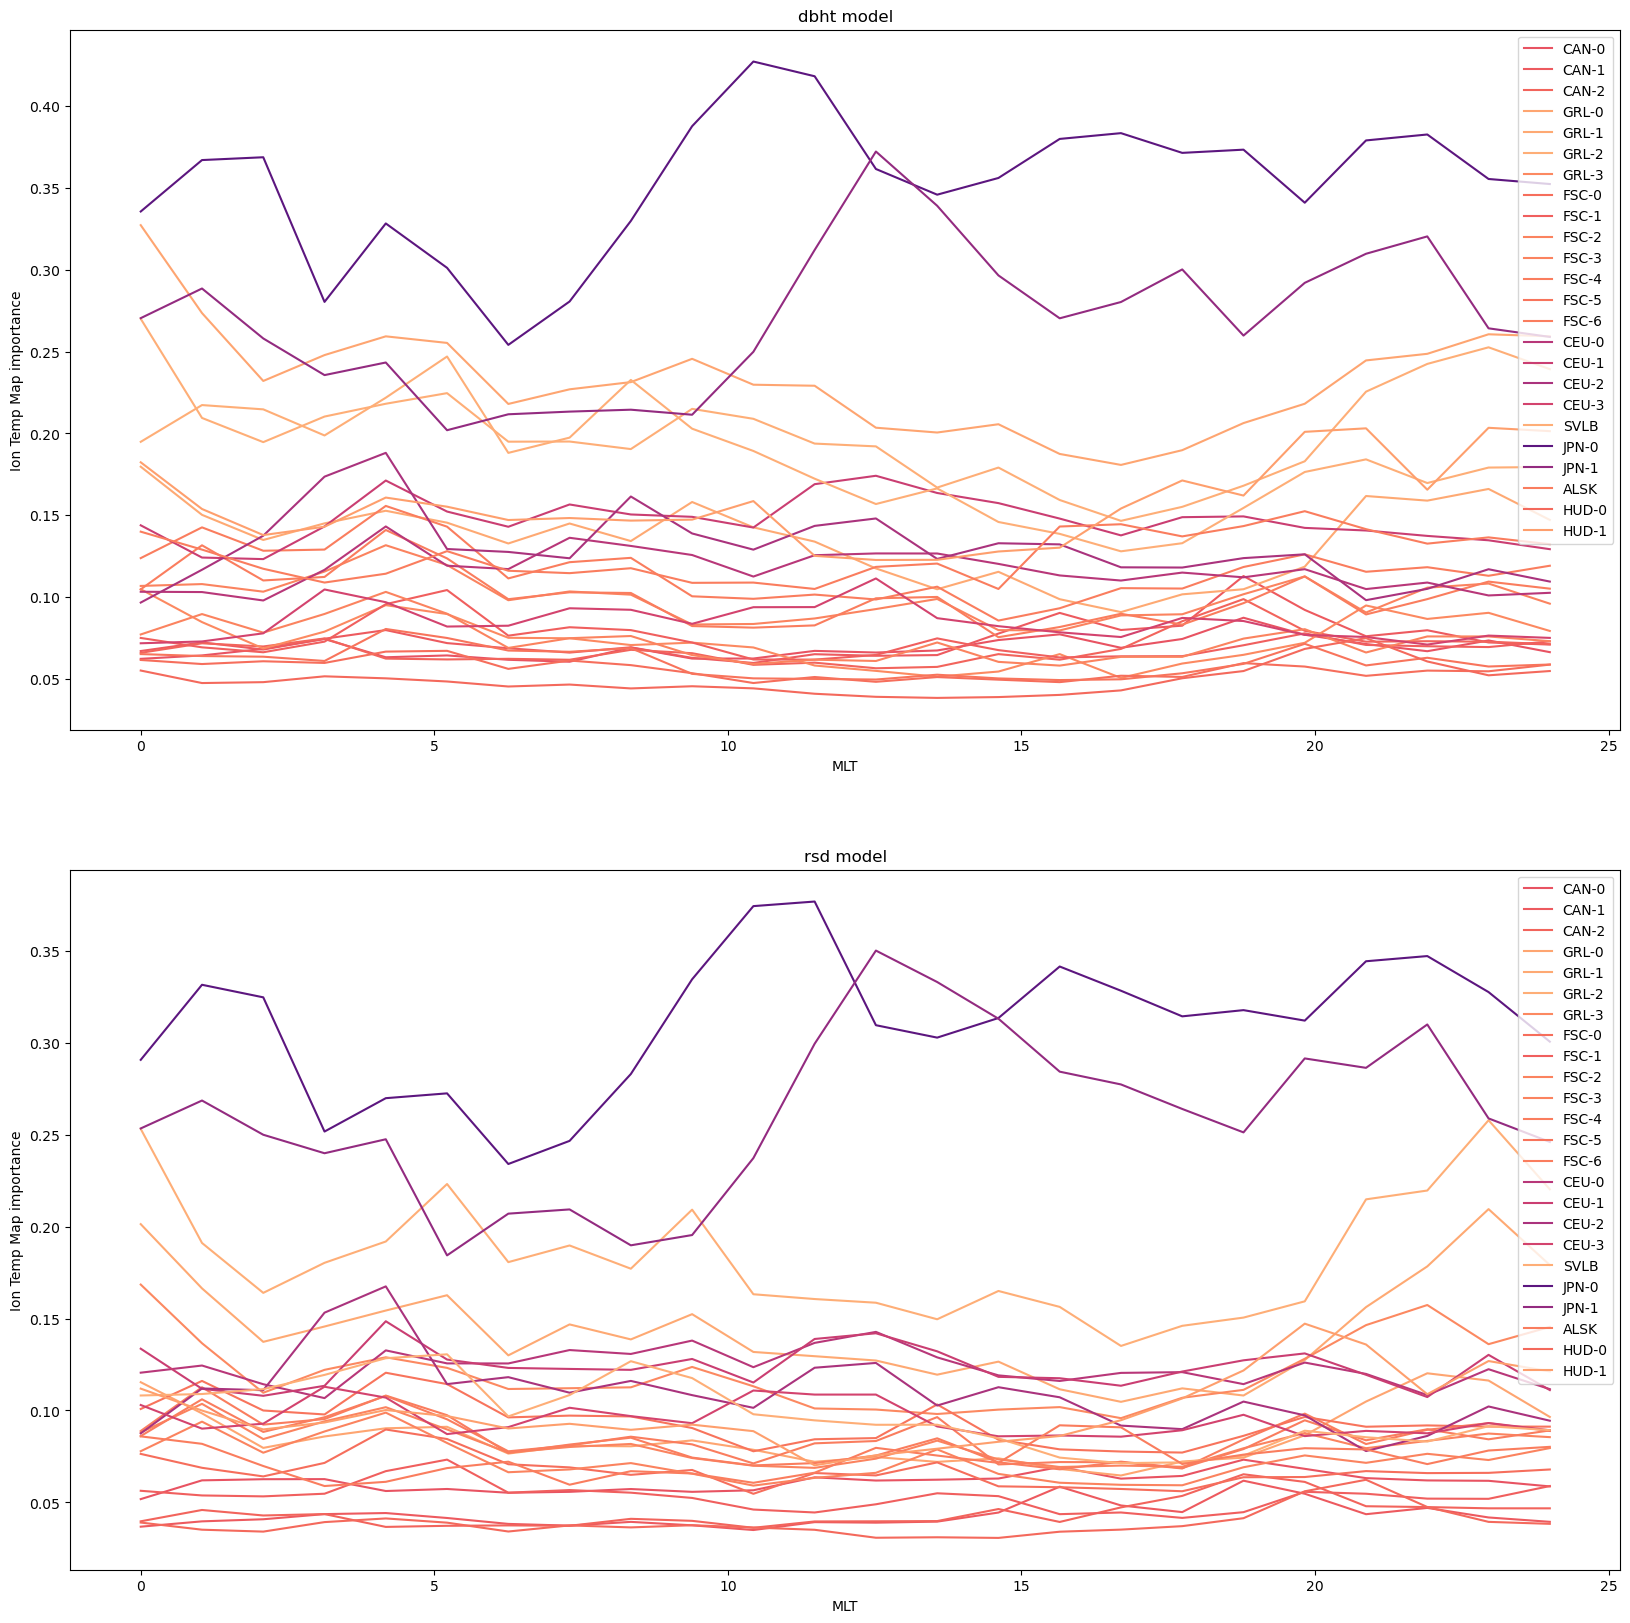

In [65]:
colors = plt.cm.magma(np.linspace(0, 1, 90))
x = np.linspace(0, 24, 24)
fig, axes = plt.subplots(2, 1, figsize=(20, 20))

for reg, region in plotting_dict.items():
	axes[0].plot(x, region['dbht'], label=reg, color=colors[int(region['mean_mlat'])])
	axes[1].plot(x, region['rsd'], label=reg, color=colors[int(region['mean_mlat'])])

axes[0].set_title('dbht model')
axes[1].set_title('rsd model')
axes[0].set_xlabel('MLT')
axes[1].set_xlabel('MLT')
axes[0].set_ylabel('Ion Temp Map importance')
axes[1].set_ylabel('Ion Temp Map importance')
axes[0].legend()
axes[1].legend()
plt.show()

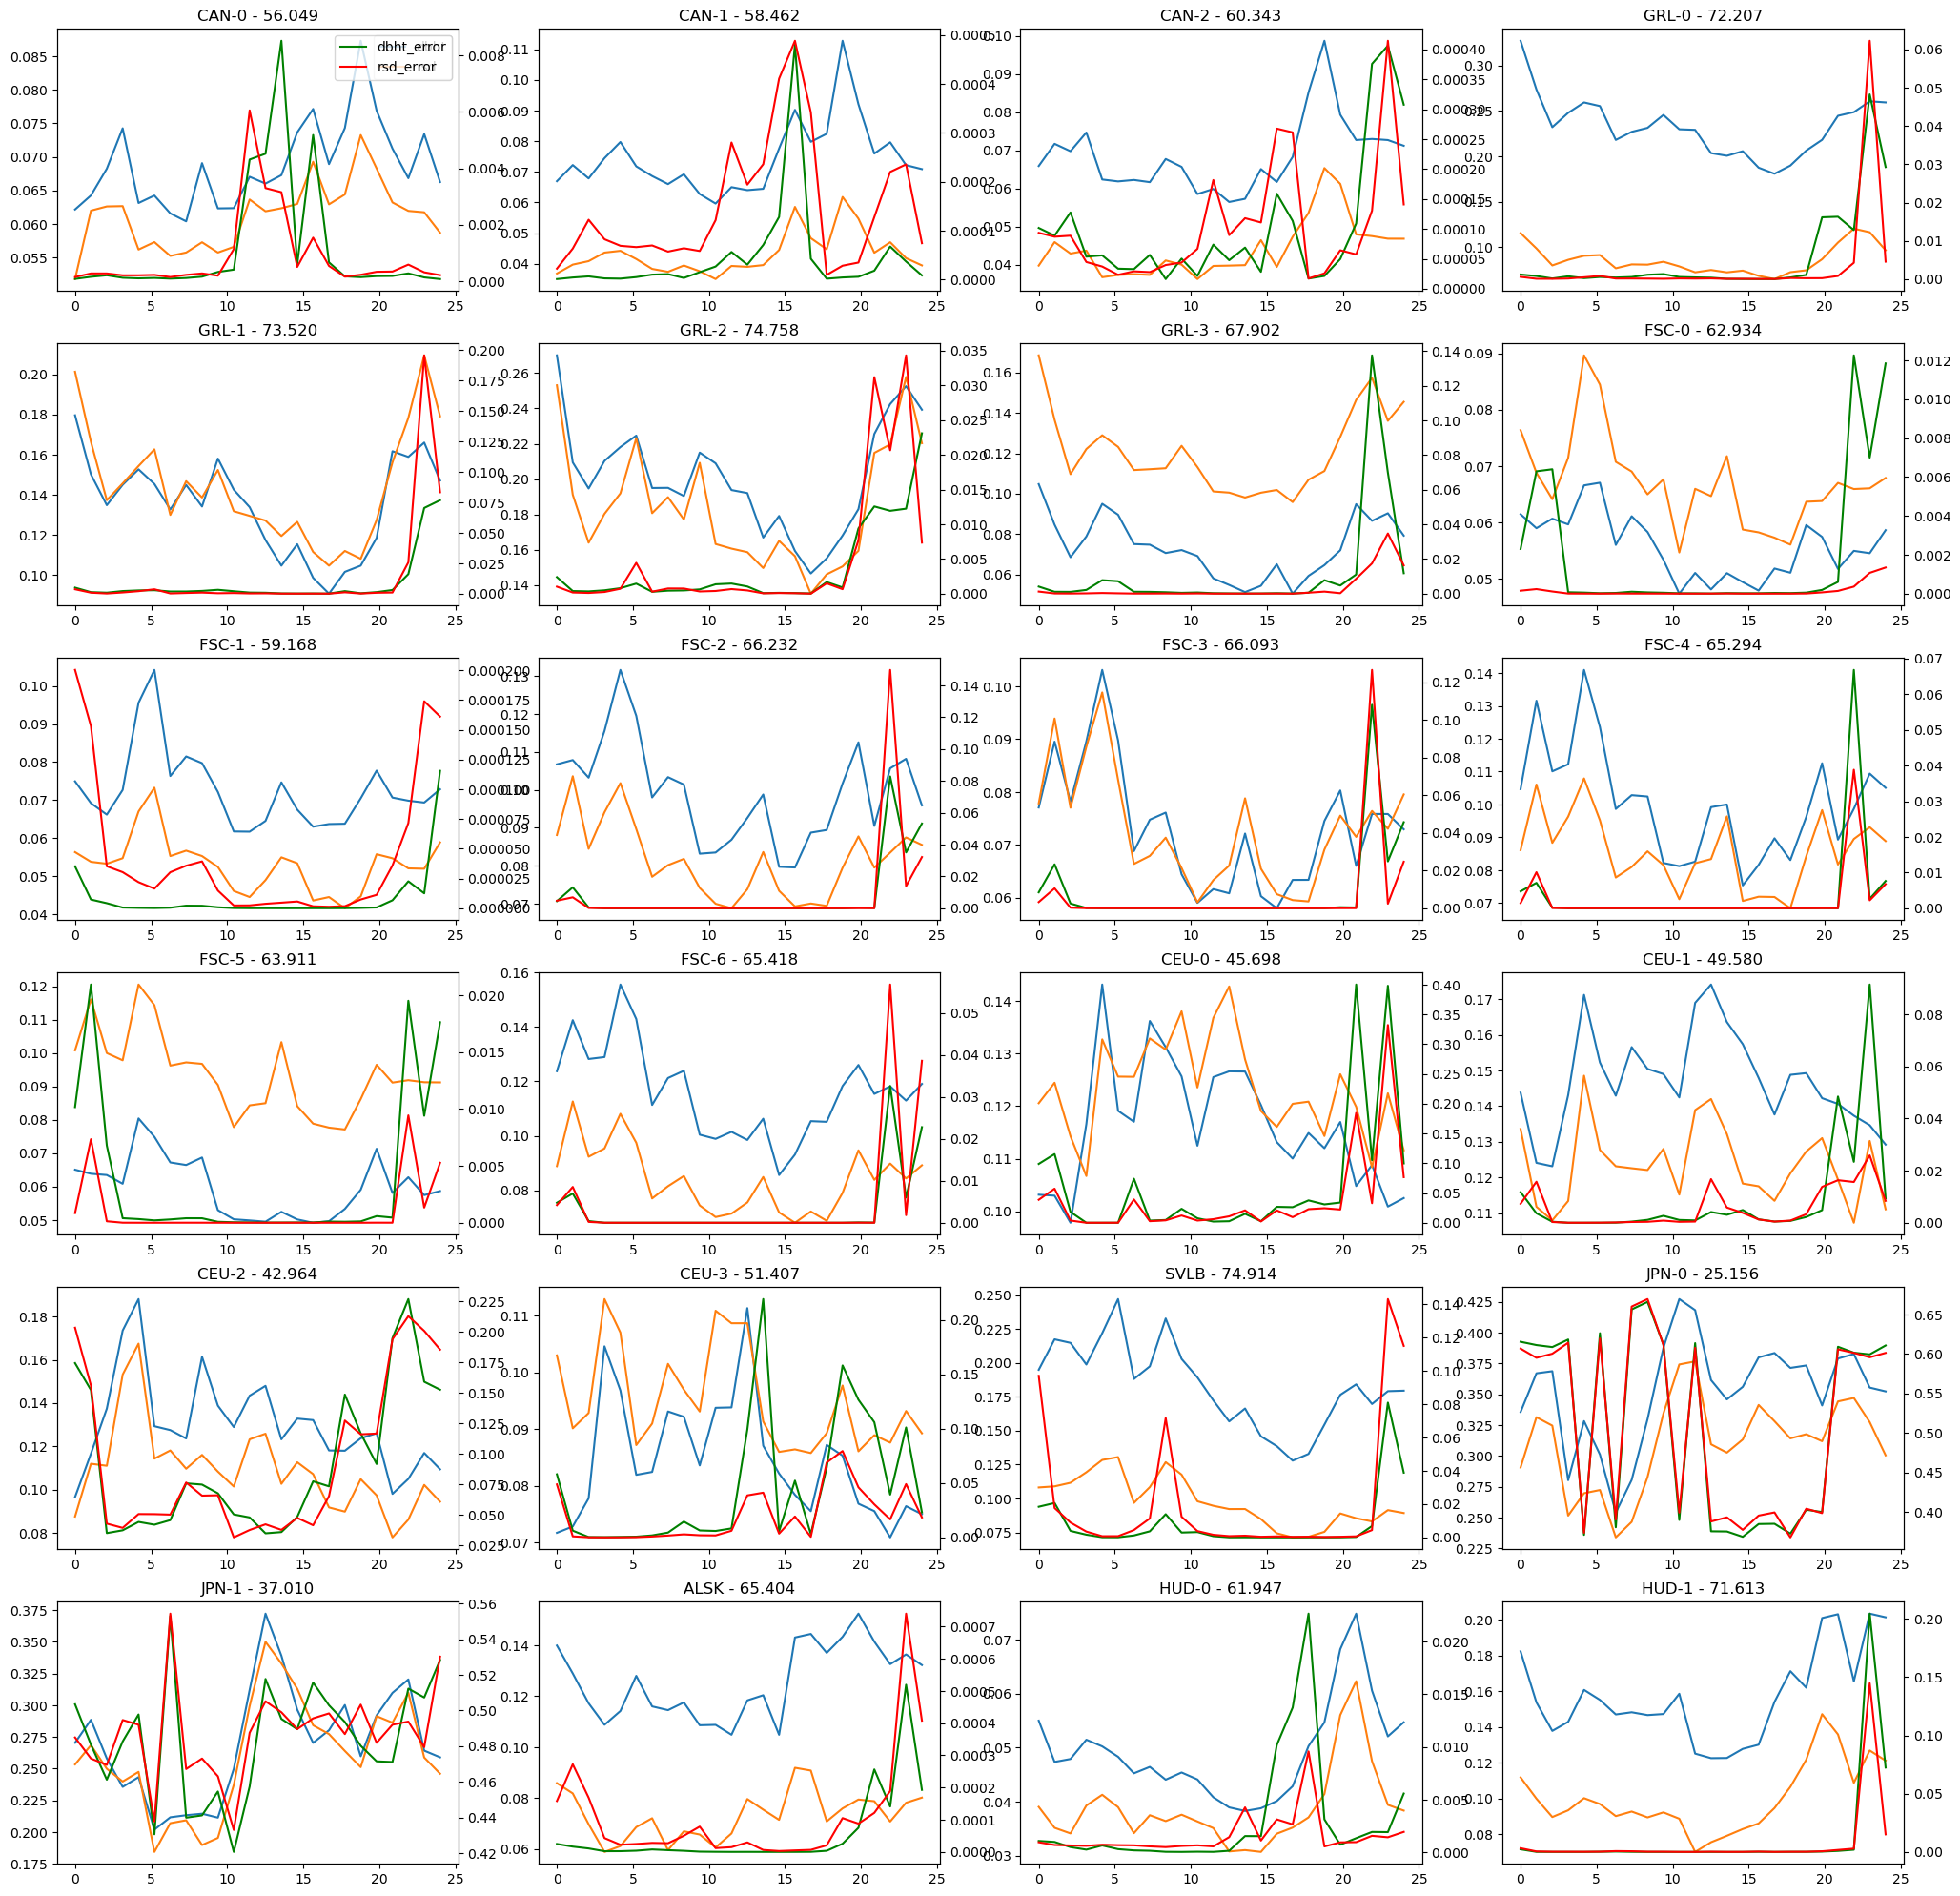

In [66]:
fig, axes = plt.subplots(6, 4, figsize=(25, 25))

for i, (reg, region) in enumerate(plotting_dict.items()):
	axes[i//4, i%4].plot(x, region['dbht'], label='dbht')
	axes[i//4, i%4].plot(x, region['rsd'], label='rsd')
	ax2 = axes[i//4, i%4].twinx()
	ax2.plot(x, region['dbht_error'], label='dbht_error', color='green')
	ax2.plot(x, region['rsd_error'], label='rsd_error', color='red')
	axes[i//4, i%4].set_title(f'{reg} - {(region["mean_mlat"]):.3f}')
	if i ==0:
		axes[i//4, i%4].legend()
		ax2.legend()
	# axes[i//4, i%4].set_xlabel('MLT')
	# axes[i//4, i%4].set_ylabel('Ion Temp Map importance')
plt.show()

In [8]:
with open('cluster_dict.pkl', 'rb') as f:
	cluster_dict = pickle.load(f)
	
for cluster in cluster_dict.keys():
	for reg, region in cluster_dict[cluster]['regions'].items():
			transforming_shap_values(region, reg, 'dbht', scalers)
			gc.collect()	
			transforming_shap_values(region, reg, 'rsd', scalers)
			gc.collect()

concat_dbht_df = concatenating_dataframes(cluster_dict, 'dbht', 'twins', 'mean', bin_mlt=True, bin_mlat=False)
concat_rsd_df = concatenating_dataframes(cluster_dict, 'rsd', 'twins', 'mean', bin_mlt=True, bin_mlat=False)

finished CAN-0 dbht
finished CAN-0 rsd
finished CAN-1 dbht
finished CAN-1 rsd
finished CAN-2 dbht
finished CAN-2 rsd
finished GRL-0 dbht
finished GRL-0 rsd
finished GRL-1 dbht
finished GRL-1 rsd
finished GRL-2 dbht
finished GRL-2 rsd
finished GRL-3 dbht
finished GRL-3 rsd
finished FSC-0 dbht
finished FSC-0 rsd
finished FSC-1 dbht
finished FSC-1 rsd
finished FSC-2 dbht
finished FSC-2 rsd
finished FSC-3 dbht
finished FSC-3 rsd
finished FSC-4 dbht
finished FSC-4 rsd
finished FSC-5 dbht
finished FSC-5 rsd
finished FSC-6 dbht
finished FSC-6 rsd
finished CEU-0 dbht
finished CEU-0 rsd
finished CEU-1 dbht
finished CEU-1 rsd
finished CEU-2 dbht
finished CEU-2 rsd
finished CEU-3 dbht
finished CEU-3 rsd
finished SVLB dbht
finished SVLB rsd
finished JPN-0 dbht
finished JPN-0 rsd
finished JPN-1 dbht
finished JPN-1 rsd
finished ALSK dbht
finished ALSK rsd
finished HUD-0 dbht
finished HUD-0 rsd
finished HUD-1 dbht
finished HUD-1 rsd
Loading station NEW....
Loading station LET....
Loading station MEA.

In [42]:
low_rsd_df = concat_rsd_df[concat_rsd_df['MLAT'] < 55]
low_dbht_df = concat_dbht_df[concat_dbht_df['MLAT'] < 55]

mid_rsd_df = concat_rsd_df[(concat_rsd_df['MLAT'] >= 55) & (concat_rsd_df['MLAT'] <= 65)]
mid_dbht_df = concat_dbht_df[(concat_dbht_df['MLAT'] >= 55) & (concat_dbht_df['MLAT'] <= 65)]

high_rsd_df = concat_rsd_df[concat_rsd_df['MLAT'] > 65]
high_dbht_df = concat_dbht_df[concat_dbht_df['MLAT'] > 65]

# n_bins = 100

# low_dbht_df['error'] = pd.cut(low_dbht_df['error'], bins=n_bins, labels=np.linspace(0, 1, n_bins))
# low_rsd_df['error'] = pd.cut(low_rsd_df['error'], bins=n_bins, labels=np.linspace(0, 1, n_bins))

# mid_dbht_df['error'] = pd.cut(mid_dbht_df['error'], bins=n_bins, labels=np.linspace(0, 1, n_bins))
# mid_rsd_df['error'] = pd.cut(mid_rsd_df['error'], bins=n_bins, labels=np.linspace(0, 1, n_bins))

# high_dbht_df['error'] = pd.cut(high_dbht_df['error'], bins=n_bins, labels=np.linspace(0, 1, n_bins))
# high_rsd_df['error'] = pd.cut(high_rsd_df['error'], bins=n_bins, labels=np.linspace(0, 1, n_bins))

# low_dbht_df = low_dbht_df.groupby('error').mean().reset_index()
# low_rsd_df = low_rsd_df.groupby('error').mean().reset_index()

# mid_dbht_df = mid_dbht_df.groupby('error').mean().reset_index()
# mid_rsd_df = mid_rsd_df.groupby('error').mean().reset_index()

# high_dbht_df = high_dbht_df.groupby('error').mean().reset_index()
# high_rsd_df = high_rsd_df.groupby('error').mean().reset_index()

low_dbht_df['shap_values'] = low_dbht_df['shap_values'].round(2)
low_rsd_df['shap_values'] = low_rsd_df['shap_values'].round(2)

mid_dbht_df['shap_values'] = mid_dbht_df['shap_values'].round(2)
mid_rsd_df['shap_values'] = mid_rsd_df['shap_values'].round(2)

high_dbht_df['shap_values'] = high_dbht_df['shap_values'].round(2)
high_rsd_df['shap_values'] = high_rsd_df['shap_values'].round(2)

# converting MLT to ints
low_dbht_df['MLT'] = low_dbht_df['MLT'].round(0)
low_rsd_df['MLT'] = low_rsd_df['MLT'].round(0)

mid_dbht_df['MLT'] = mid_dbht_df['MLT'].round(0)
mid_rsd_df['MLT'] = mid_rsd_df['MLT'].round(0)

high_dbht_df['MLT'] = high_dbht_df['MLT'].round(0)
high_rsd_df['MLT'] = high_rsd_df['MLT'].round(0)


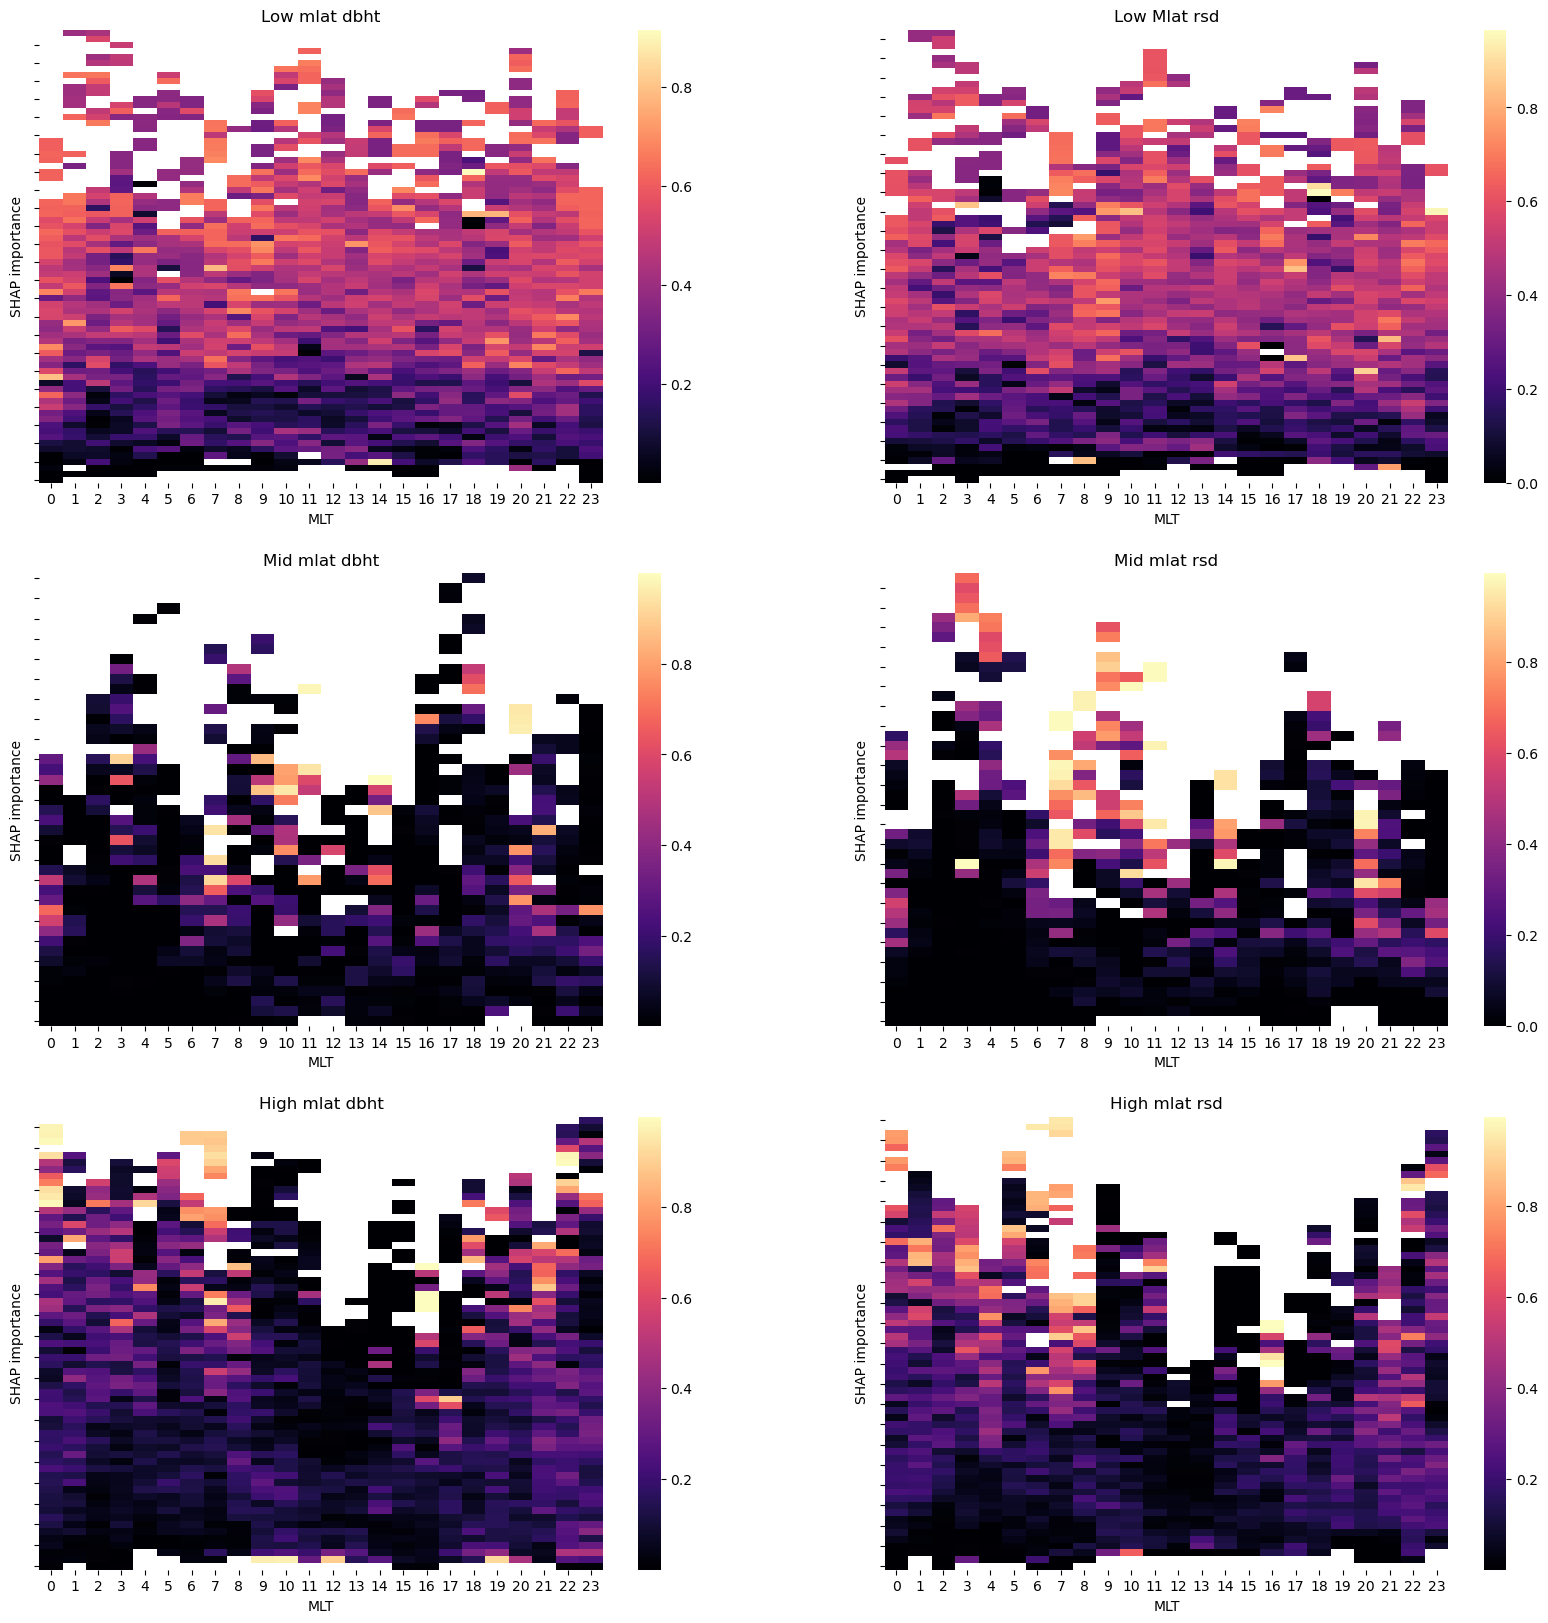

In [45]:
low_rsd_pivot = low_rsd_df.pivot_table(index='shap_values', columns='MLT', values='error', aggfunc='mean')
low_dbht_pivot = low_dbht_df.pivot_table(index='shap_values', columns='MLT', values='error', aggfunc='mean')

mid_rsd_pivot = mid_rsd_df.pivot_table(index='shap_values', columns='MLT', values='error', aggfunc='mean')
mid_dbht_pivot = mid_dbht_df.pivot_table(index='shap_values', columns='MLT', values='error', aggfunc='mean')

high_rsd_pivot = high_rsd_df.pivot_table(index='shap_values', columns='MLT', values='error', aggfunc='mean')
high_dbht_pivot = high_dbht_df.pivot_table(index='shap_values', columns='MLT', values='error', aggfunc='mean')

# fig, axes = plt.subplots(3, 1, figsize=(20, 20))

# axes[0].plot(low_dbht_df['error'], low_dbht_df['shap_values'], label='dbht')
# axes[0].plot(low_rsd_df['error'], low_rsd_df['shap_values'], label='rsd')
# axes[0].legend()
# axes[0].set_title('low mlat')
# axes[0].set_ylabel('shap values')
# axes[0].set_xlabel('error')
# axes[0].margins(x=0, y=0)

# axes[1].plot(mid_dbht_df['error'], mid_dbht_df['shap_values'], label='dbht')
# axes[1].plot(mid_rsd_df['error'], mid_rsd_df['shap_values'], label='rsd')
# axes[1].legend()
# axes[1].set_title('mid mlat')
# axes[1].set_ylabel('shap values')
# axes[1].set_xlabel('error')
# axes[1].margins(x=0, y=0)

# axes[2].plot(high_dbht_df['error'], high_dbht_df['shap_values'], label='dbht')
# axes[2].plot(high_rsd_df['error'], high_rsd_df['shap_values'], label='rsd')
# axes[2].legend()
# axes[2].set_title('high mlat')
# axes[2].set_ylabel('shap values')
# axes[2].set_xlabel('error')
# axes[2].margins(x=0, y=0)

# plt.show()

fig, axes = plt.subplots(3, 2, figsize=(20, 20))

sns.heatmap(low_dbht_pivot, ax=axes[0,0], cmap='magma')
axes[0,0].set_title('Low mlat dbht')
axes[0,0].set_ylabel('SHAP importance')
axes[0,0].set_xlabel('MLT')
axes[0,0].set_yticklabels([])
axes[0,0].invert_yaxis()


sns.heatmap(low_rsd_pivot, ax=axes[0,1], cmap='magma')
axes[0,1].set_title('Low Mlat rsd')
axes[0,1].set_ylabel('SHAP importance')
axes[0,1].set_xlabel('MLT')
axes[0,1].set_yticklabels([])
axes[0,1].invert_yaxis()

sns.heatmap(mid_dbht_pivot, ax=axes[1,0], cmap='magma')
axes[1,0].set_title('Mid mlat dbht')
axes[1,0].set_ylabel('SHAP importance')
axes[1,0].set_xlabel('MLT')
axes[1,0].set_yticklabels([])
axes[1,0].invert_yaxis()

sns.heatmap(mid_rsd_pivot, ax=axes[1,1], cmap='magma')
axes[1,1].set_title('Mid mlat rsd')
axes[1,1].set_ylabel('SHAP importance')
axes[1,1].set_xlabel('MLT')
axes[1,1].set_yticklabels([])
axes[1,1].invert_yaxis()

sns.heatmap(high_dbht_pivot, ax=axes[2,0], cmap='magma')
axes[2,0].set_title('High mlat dbht')
axes[2,0].set_ylabel('SHAP importance')
axes[2,0].set_xlabel('MLT')
axes[2,0].set_yticklabels([])
axes[2,0].invert_yaxis()

sns.heatmap(high_rsd_pivot, ax=axes[2,1], cmap='magma')
axes[2,1].set_title('High mlat rsd')
axes[2,1].set_ylabel('SHAP importance')
axes[2,1].set_xlabel('MLT')
axes[2,1].set_yticklabels([])
axes[2,1].invert_yaxis()

plt.show()


               error         actual     predicted
count  245514.000000  245514.000000  2.455140e+05
mean        0.152855       0.193736  2.146279e-01
std         0.280853       0.395167  3.435003e-01
min         0.000000       0.000000  1.000000e-09
25%         0.000016       0.000000  1.646197e-05
50%         0.000661       0.000000  7.118588e-04
75%         0.147610       0.000000  4.413213e-01
max         1.000000       1.000000  1.000000e+00
               error         actual     predicted
count  245500.000000  245500.000000  2.455000e+05
mean        0.144721       0.193747  2.154124e-01
std         0.274584       0.395178  3.473219e-01
min         0.000000       0.000000  1.000000e-09
25%         0.000013       0.000000  1.465877e-05
50%         0.000420       0.000000  5.030959e-04
75%         0.117527       0.000000  4.360933e-01
max         1.000000       1.000000  1.000000e+00


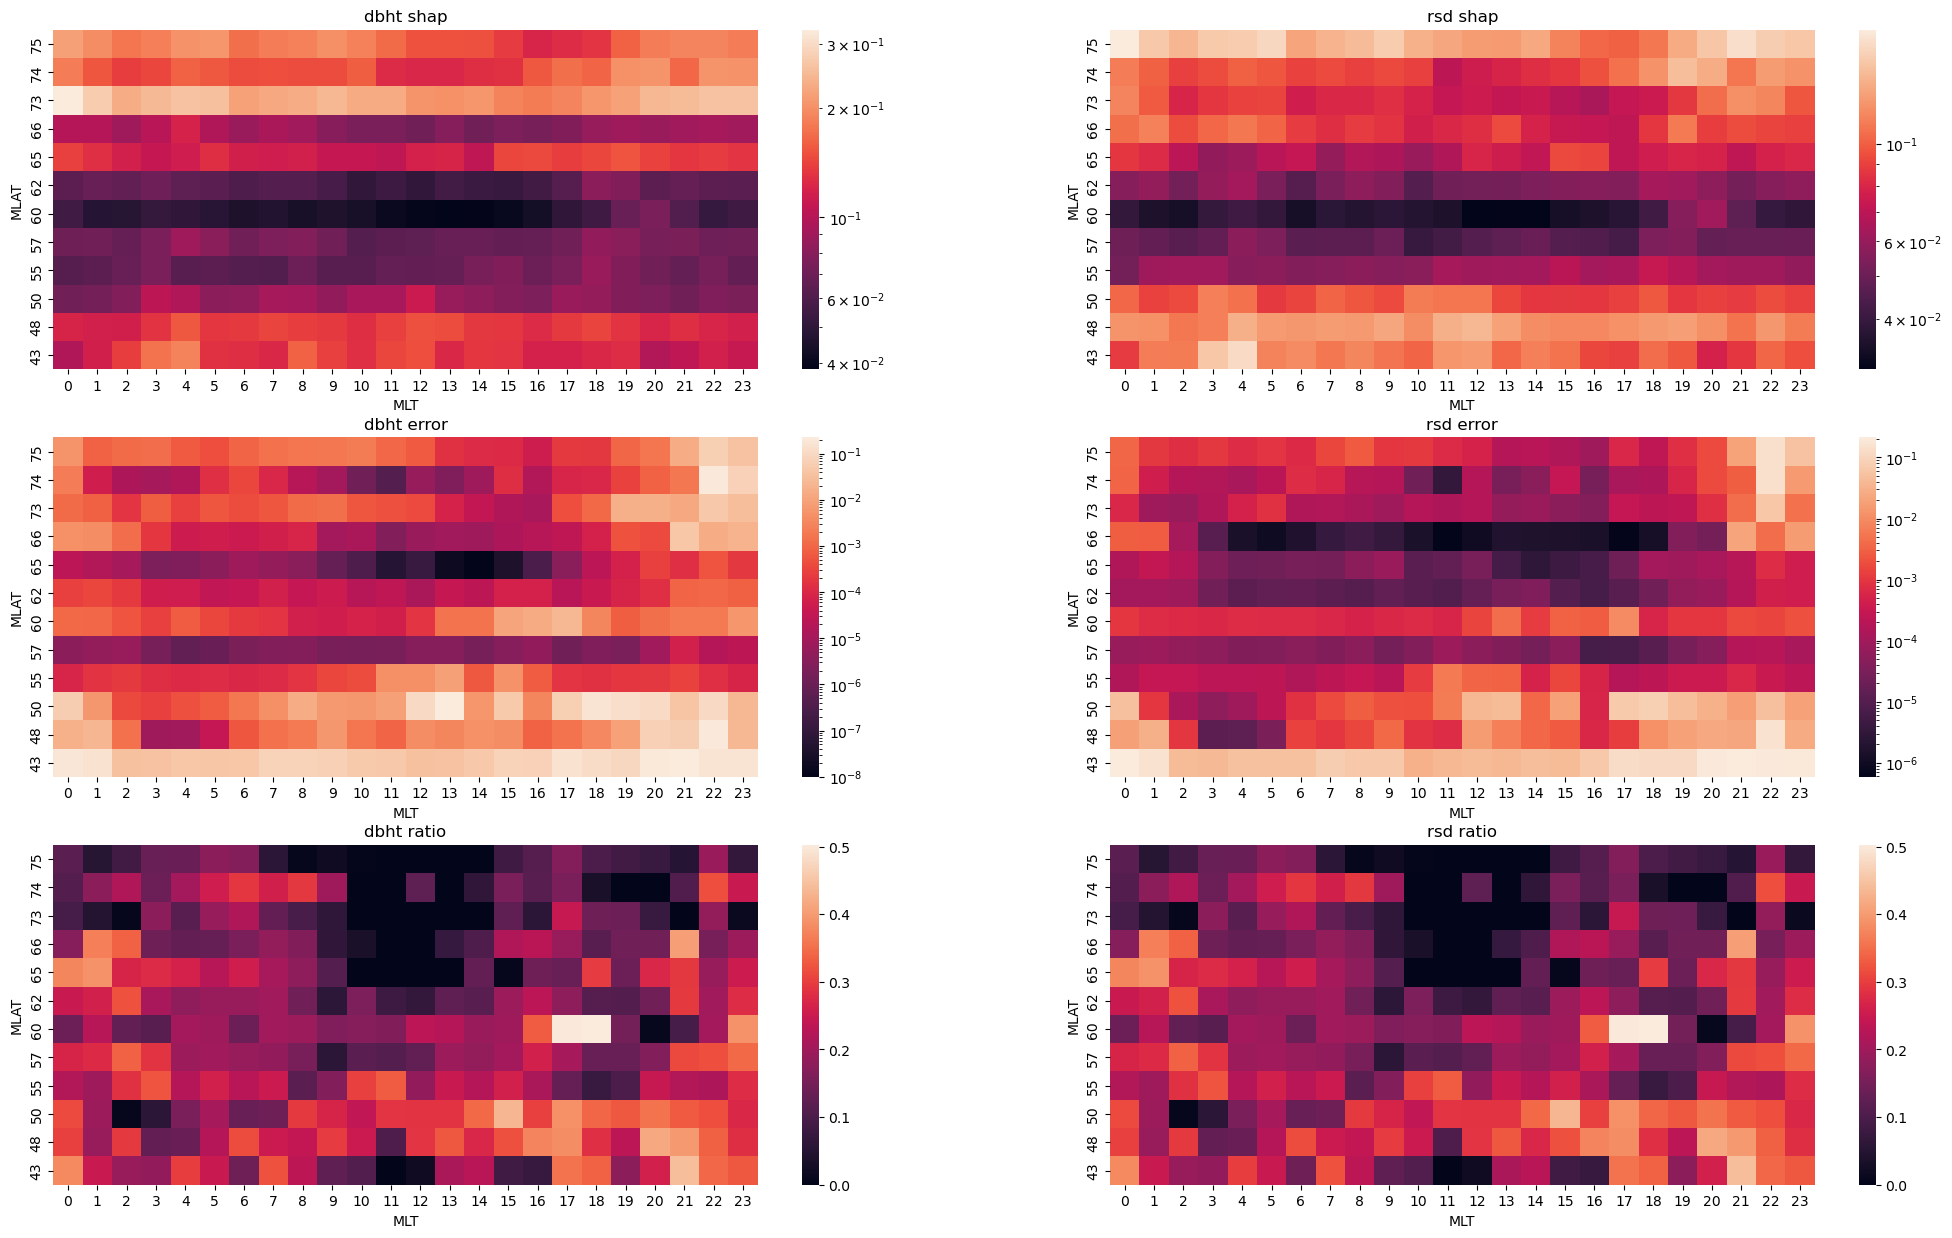

In [18]:
def customagg(series):
	return series.sum()/len(series)

print(concat_dbht_df[['error', 'actual', 'predicted']].describe())
print(concat_rsd_df[['error', 'actual', 'predicted']].describe())

pivot_shap_dbht = concat_dbht_df.pivot_table(index='MLAT', columns='MLT', values='shap_values', aggfunc='median')
pivot_shap_rsd = concat_rsd_df.pivot_table(index='MLAT', columns='MLT', values='shap_values', aggfunc='median')
pivot_error_dbht = concat_dbht_df.pivot_table(index='MLAT', columns='MLT', values='error', aggfunc='median')
pivot_error_rsd = concat_rsd_df.pivot_table(index='MLAT', columns='MLT', values='error', aggfunc='median')
pivot_ratio_dbht = concat_dbht_df.pivot_table(index='MLAT', columns='MLT', values='actual', aggfunc=customagg)
pivot_ratio_rsd = concat_rsd_df.pivot_table(index='MLAT', columns='MLT', values='actual', aggfunc=customagg)

ratio_diff = pivot_ratio_dbht - pivot_ratio_rsd

pivot_shap_dbht.drop([24, 37], axis=0, inplace=True)
pivot_shap_rsd.drop([24, 37], axis=0, inplace=True)
pivot_error_dbht.drop([24, 37], axis=0, inplace=True)
pivot_error_rsd.drop([24, 37], axis=0, inplace=True)
pivot_ratio_dbht.drop([24, 37], axis=0, inplace=True)
pivot_ratio_rsd.drop([24, 37], axis=0, inplace=True)

fig, axes = plt.subplots(3, 2, figsize=(25, 15))
im0 = sns.heatmap(pivot_shap_dbht, ax=axes[0,0], norm=mpl.colors.LogNorm())
im1 = sns.heatmap(pivot_shap_rsd, ax=axes[0,1], norm=mpl.colors.LogNorm())
axes[0,0].invert_yaxis()
axes[0,1].invert_yaxis()
# plt.colorbar(im0)
# plt.colorbar(im1)
axes[0,0].set_title('dbht shap')
axes[0,1].set_title('rsd shap')

im2 = sns.heatmap(pivot_error_dbht, ax=axes[1,0], norm=mpl.colors.LogNorm())
im3 = sns.heatmap(pivot_error_rsd, ax=axes[1,1], norm=mpl.colors.LogNorm())
axes[1,0].invert_yaxis()
axes[1,1].invert_yaxis()
# plt.colorbar(im2)
# plt.colorbar(im3)
axes[1,0].set_title('dbht error')
axes[1,1].set_title('rsd error')

im4 = sns.heatmap(pivot_ratio_dbht, ax=axes[2,0])
im5 = sns.heatmap(pivot_ratio_rsd, ax=axes[2,1])
axes[2,0].invert_yaxis()
axes[2,1].invert_yaxis()

axes[2,0].set_title('dbht ratio')
axes[2,1].set_title('rsd ratio')

plt.show()

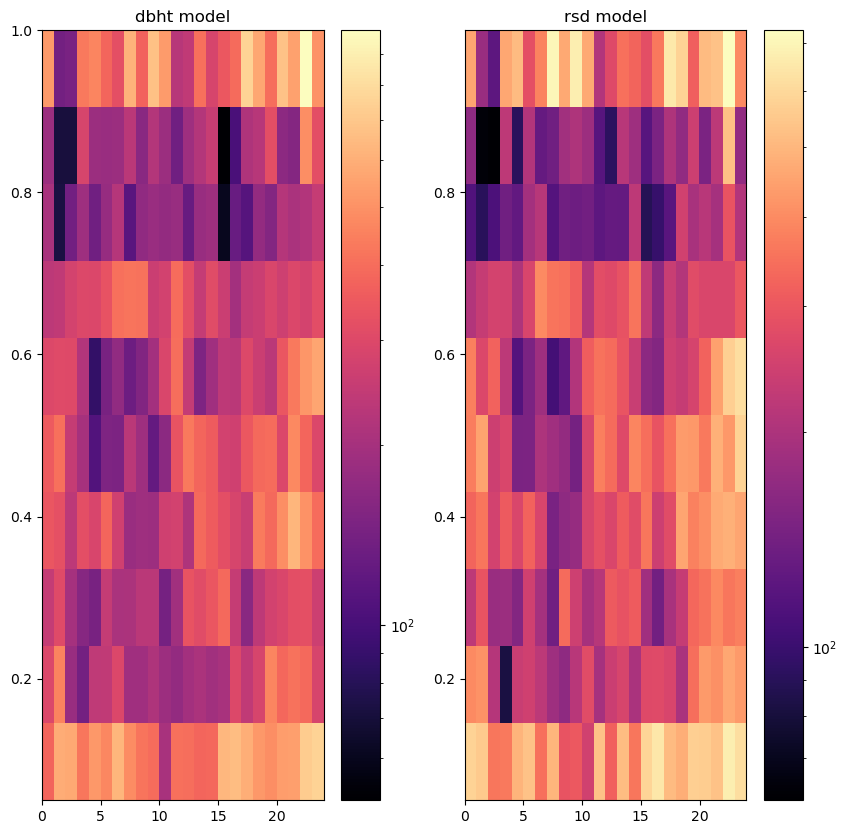

In [14]:
concat_dbht_df = concat_dbht_df[concat_dbht_df['error'] > 0.05]
concat_rsd_df = concat_rsd_df[concat_rsd_df['error'] > 0.05]
fig, axes = plt.subplots(1, 2, figsize=(10, 10))

im0 = axes[0].hist2d(concat_dbht_df['MLT'], concat_dbht_df['error'], bins=(24, 10), cmap='magma', norm=mpl.colors.LogNorm())
im1 = axes[1].hist2d(concat_rsd_df['MLT'], concat_rsd_df['error'], bins=(24, 10), cmap='magma', norm=mpl.colors.LogNorm())
plt.colorbar(im0[3], ax=axes[0])
plt.colorbar(im1[3], ax=axes[1])
axes[0].set_title('dbht model')
axes[1].set_title('rsd model')
plt.show()

In [46]:
def mlt_wedge(img_data, mlt_min: int = 18, mlt_max: int = 6, center_x: int = 120, center_y: int = 80):
    """
    This function takes in a temperature ENA image and divides thems into pie slices based on the
    numbers of slices desired. The output of the function is an array of the mean different sections of the
    ENA temperature map generated and the different sections themselves, respectively.
    Parameters:
    -----------
    img_data : ndarray
        Input image data.
    mlt_min : int, optional
        Minimum MLT value. Default is 18.
    mlt_max : int, optional
        Maximum MLT value. Default is 6.
    mlt_span : int, optional
        MLT span. Default is 1.
    angle_steps : int, optional
        Number of angle steps for pie slices. Default is 8.
    center_x : int, optional
        X-coordinate of the center. Default is 120.
    center_y : int, optional
        Y-coordinate of the center. Default is 80.
    Returns:
    --------
    selected_sections : list
        List of selected pie slice sections.
    """
    # get the dimension of the image
    height, width = img_data.shape
    # Create an empty list to store the selected sections
    selected_sections = []
    img_mean = []
    # define the numbers of angles used for the pie slices
    # Create masks for each N-degree section and apply them to the image
    # Create a new blank mask as a NumPy array
    mask = np.zeros((height, width), dtype=np.uint8)
    img_copy = np.copy(img_data)
    # Calculate the coordinates of the sector's bounding box

    start_angle = (mlt_min*15) % 360
    end_angle = (mlt_max*15) % 360

    # print(f'start_angle: {start_angle}, end_angle: {end_angle}')
    # Calculate the coordinates of the sector arc
    for y in range(height):
        for x in range(width):
            # Calculate the polar coordinates of the pixel relative to the image center
            dx = center_x - x
            dy = center_y - y
            pixel_angle = math.degrees(math.atan2(dy, dx))  # Calculate the angle in radians
            if pixel_angle < 0:
                pixel_angle += 360
            # Check if the pixel is within the current 45-degree section
            if mlt_min > mlt_max:
                if start_angle <= pixel_angle < 360 or 0 <= pixel_angle < end_angle:
                    mask[y, x] = 1
            else:
                if start_angle <= pixel_angle < end_angle:
                    mask[y, x] = 1  # Set the pixel to white (255)
    # Apply the mask to the heat map to select the section
    img_copy[mask == 0] = 0
    # Append the selected section to the list
    selected_sections = img_copy
    xx = np.copy(img_copy)
    xx[xx == 0] = np.nan
    # Get the mean of the non zero values of the image
    img_mean.append(np.nanmean(xx))
    # print(f'mean: {np.nanmean(xx)}')
    return img_mean, selected_sections

In [9]:
# key = '2012-03-07 01:50:00'
# cluster = 'greenland_cluster'
# region = 'GRL-0'
# cluster = 'canadian_cluster'
# region = 'CAN-2'
# if region in list_of_oversampled_regions:
# 	results = pd.read_feather(f'{results_dir}/twins_modeling_region_{region}_version_twins_v_maxpooling_oversampling.feather')
# else:
# 	results = pd.read_feather(f'{results_dir}/twins_modeling_region_{region}_version_twins_v_maxpooling.feather')
# mlt_station = utils.loading_supermag(cluster_dict[cluster]['regions'][region]['mlt_station'])

In [10]:
# i = 6864
# mlt = mlt_station[mlt_station.index == cluster_dict[cluster]['regions'][region]['twins_shap']['Date_UTC'].iloc[i][0]]['MLT'].values[0]
# pred_mean = results['predicted_mean'].iloc[i]
# mlt_min = mlt-2 if mlt >=2 else 24+mlt-2
# mlt_max = mlt+2 if mlt <=22 else mlt-24+2
# full_img_mean, full_selected_sections = mlt_wedge(cluster_dict[cluster]['regions'][region]['twins_shap']['twins_mean_shap'][i], mlt_min=mlt_min, mlt_max=mlt_max, center_x=70, center_y=45)
# fig, ax = plt.subplots(2, 2, figsize=(20, 15))
# plt.suptitle(f"{cluster_dict[cluster]['regions'][region]['twins_shap']['Date_UTC'].iloc[i][0]} - Ground Truth: {cluster_dict[cluster]['regions'][region]['twins_shap']['ytest'][i]} - MLT: {mlt:.2f} - Prediction: {pred_mean:.4f}", fontsize=20)
# vmin = np.nanmin(cluster_dict[cluster]['regions'][region]['twins_shap']['twins_mean_shap'][i])
# vmax = np.nanmax(cluster_dict[cluster]['regions'][region]['twins_shap']['twins_mean_shap'][i])
# limit = np.max([np.abs(vmin), np.abs(vmax)])
# ax[0,0].set_title(f'{region} SHAP Values')
# im0 = ax[0,0].imshow(cluster_dict[cluster]['regions'][region]['twins_shap']['twins_mean_shap'][i], cmap='coolwarm', vmin=-limit, vmax=limit, origin='lower')
# ax[1,0].axhline(y=45, color='r', linestyle='--')
# ax[0,1].imshow(full_selected_sections, cmap='coolwarm', vmin=-limit, vmax=limit, origin='lower')
# fig.colorbar(im0, ax=ax[0,1])

# vmax = np.nanmax(cluster_dict[cluster]['regions'][region]['twins_shap']['testing_data'][1][i])
# window_img_mean, window_selected_sections = mlt_wedge(cluster_dict[cluster]['regions'][region]['twins_shap']['testing_data'][1][i], mlt_min=mlt_min, mlt_max=mlt_max, center_x=70, center_y=45)
# im1 = ax[1,0].imshow(cluster_dict[cluster]['regions'][region]['twins_shap']['testing_data'][1][i], origin='lower', vmin=0, vmax=vmax)
# ax[1,0].axhline(y=45, color='r', linestyle='--')
# im1 = ax[1,1].imshow(window_selected_sections, origin='lower', vmin=0, vmax=vmax)
# fig.colorbar(im1, ax=ax[1,1])

# # show plot with tight layout
# plt.tight_layout()
# plt.show()

/tmp/ipykernel_3092032/2690567953.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.suptitle(f"{cluster_dict[cluster]['regions'][region]['dbht']['Date_UTC'].iloc[i][0]} - Ground Truth: {cluster_dict[cluster]['regions'][region]['dbht']['ytest'][i]}", fontsize=20)


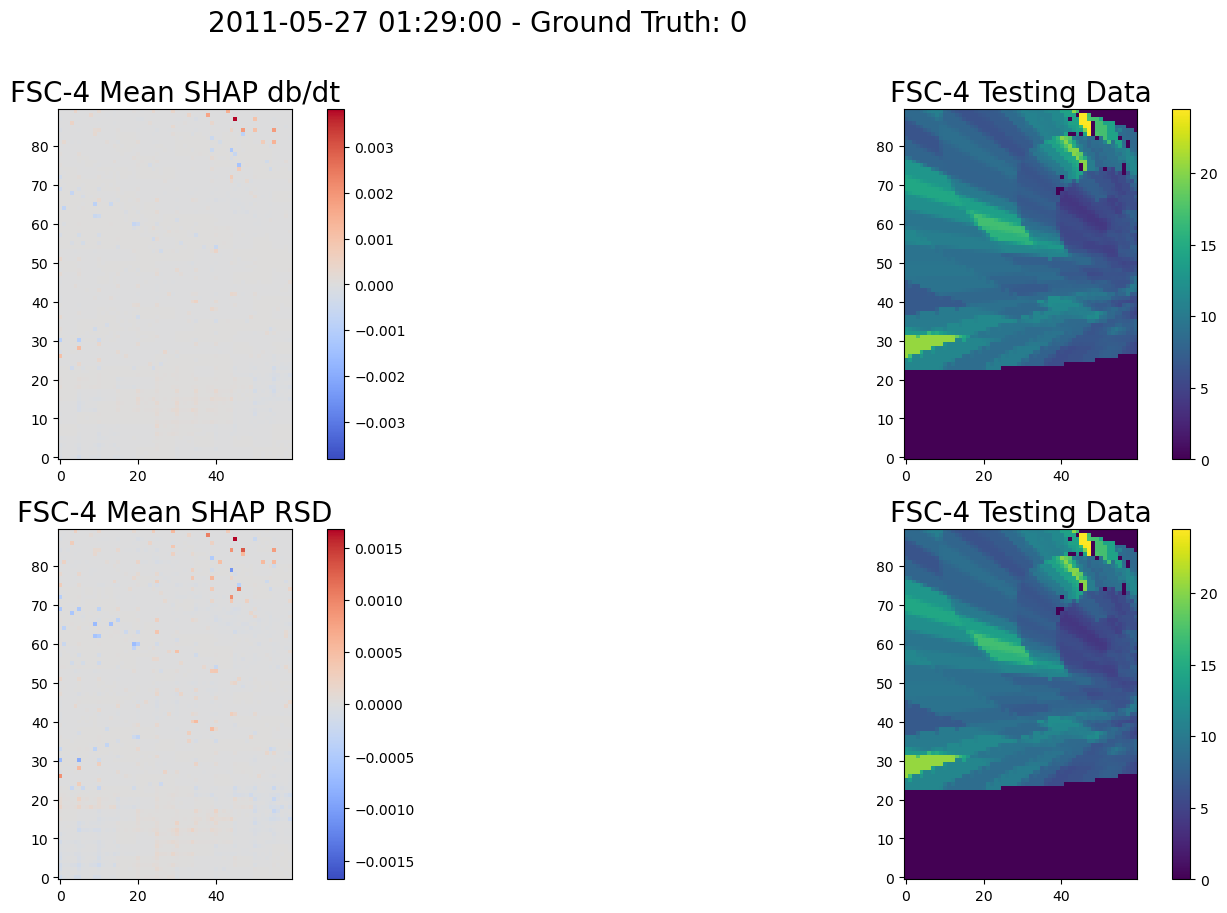

: 

In [47]:
cluster = 'fennoscandinavian_cluster'
region = 'FSC-4'
# cluster = 'canadian_cluster'
# region = 'CAN-2'
positive_list = cluster_dict[cluster]['regions'][region]['dbht']['ytest'] == 1
# getting True indicies
positive_list = np.where(positive_list)[0]
# j=3769
# i = positive_list[j]
i = 2769

fig, axes = plt.subplots(2, 2, figsize=(20, 10))
# doing imshow with colorbar
plt.suptitle(f"{cluster_dict[cluster]['regions'][region]['dbht']['Date_UTC'].iloc[i][0]} - Ground Truth: {cluster_dict[cluster]['regions'][region]['dbht']['ytest'][i]}", fontsize=20)
extreme = np.max(np.abs(cluster_dict[cluster]['regions'][region]['dbht']['twins_mean_shap'][i]))
im = axes[0,0].imshow(cluster_dict[cluster]['regions'][region]['dbht']['twins_mean_shap'][i], cmap='coolwarm', vmin=-extreme, vmax=extreme, origin='lower')
fig.colorbar(im, ax=axes[0,0])
axes[0,0].set_title(f'{region} Mean SHAP db/dt', fontsize=20)

im = axes[0,1].imshow(cluster_dict[cluster]['regions'][region]['dbht']['testing_data'][1][i], origin='lower')
fig.colorbar(im, ax=axes[0,1])
axes[0,1].set_title(f'{region} Testing Data', fontsize=20)

extreme = np.max(np.abs(cluster_dict[cluster]['regions'][region]['rsd']['twins_mean_shap'][i]))
im = axes[1,0].imshow(cluster_dict[cluster]['regions'][region]['rsd']['twins_mean_shap'][i], cmap='coolwarm', vmin=-extreme, vmax=extreme, origin='lower')
fig.colorbar(im, ax=axes[1,0])
axes[1,0].set_title(f'{region} Mean SHAP RSD', fontsize=20)

im = axes[1,1].imshow(cluster_dict[cluster]['regions'][region]['rsd']['testing_data'][1][i], origin='lower')
fig.colorbar(im, ax=axes[1,1])
axes[1,1].set_title(f'{region} Testing Data', fontsize=20)

plt.show()

Loading station BEL....


  0%|          | 0/10684 [00:00<?, ?it/s]/tmp/ipykernel_3092032/4265609134.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mlt = mlt_station[mlt_station.index == cluster_dict[cluster]['regions'][region][target]['Date_UTC'].iloc[i][0]]['MLT'].values[0]
100%|██████████| 10684/10684 [03:16<00:00, 54.37it/s]


empty maps: 0


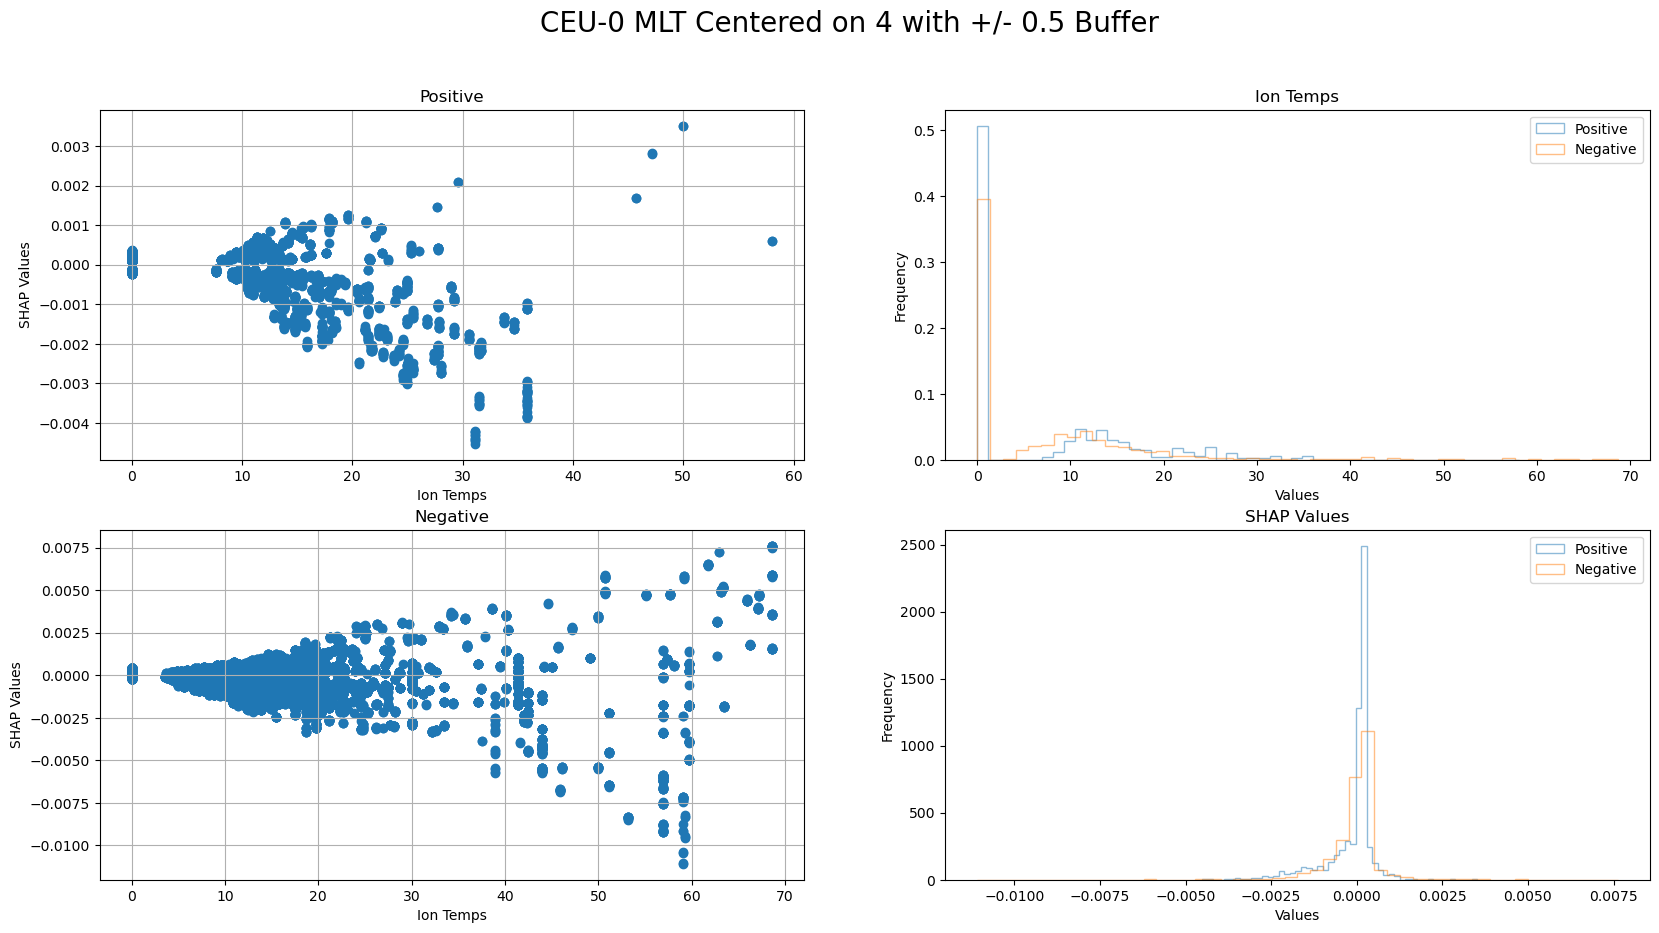

In [12]:
cluster = 'central_european_cluster'
region = 'CEU-0'
target='rsd'
full, window = [], []
specific_mlt = 4
mlt_buff = 0.5
mlt_lower = specific_mlt - mlt_buff if specific_mlt >= mlt_buff else 24 - mlt_buff + specific_mlt
mlt_upper = specific_mlt + mlt_buff if specific_mlt <= (24-mlt_buff) else specific_mlt - 24 + mlt_buff
# if region in list_of_oversampled_regions:
# 	results = pd.read_feather(f'{results_dir}/twins_modeling_region_{region}_version_twins_v_maxpooling_oversampling.feather')
# else:
# 	results = pd.read_feather(f'{results_dir}/twins_modeling_region_{region}_version_twins_v_maxpooling.feather')
mlt_station = utils.loading_supermag(cluster_dict[cluster]['regions'][region]['mlt_station'])
empty_maps = 0
plotting_df = pd.DataFrame()
for i in tqdm.tqdm(range(len(cluster_dict[cluster]['regions'][region][target]['Date_UTC']))):
	if len(np.unique(cluster_dict[cluster]['regions'][region][target]['twins_mean_shap'][i])) == 1:
		empty_maps += 1
	mlt = mlt_station[mlt_station.index == cluster_dict[cluster]['regions'][region][target]['Date_UTC'].iloc[i][0]]['MLT'].values[0]
	mlt_min = mlt-2 if mlt >=2 else 24+mlt-2
	mlt_max = mlt + 2 if mlt <= 22 else mlt-24+2

	if (mlt+mlt_buff) >= 24:
		if mlt <= mlt_lower and mlt >= mlt_upper:
			full_img_mean, full_selected_sections = mlt_wedge(cluster_dict[cluster]['regions'][region][target]['twins_mean_shap'][i], mlt_min=mlt_min, mlt_max=mlt_max, center_x=70, center_y=45)
			window_img_mean, window_selected_sections = mlt_wedge(cluster_dict[cluster]['regions'][region][target]['testing_data'][1][i], mlt_min=mlt_min, mlt_max=mlt_max, center_x=70, center_y=45)
			
			temp_df = pd.DataFrame({'full': full_selected_sections.flatten(), 'window': window_selected_sections.flatten(), 'ground_truth': cluster_dict[cluster]['regions'][region][target]['ytest'][i]})
			plotting_df = pd.concat([plotting_df, temp_df], axis=0, ignore_index=True)
			
	else:
		if mlt >= mlt_lower and mlt <= mlt_upper:
			full_img_mean, full_selected_sections = mlt_wedge(cluster_dict[cluster]['regions'][region][target]['twins_mean_shap'][i], mlt_min=mlt_min, mlt_max=mlt_max, center_x=70, center_y=45)
			window_img_mean, window_selected_sections = mlt_wedge(cluster_dict[cluster]['regions'][region][target]['testing_data'][1][i], mlt_min=mlt_min, mlt_max=mlt_max, center_x=70, center_y=45)
			
			temp_df = pd.DataFrame({'full': full_selected_sections.flatten(), 'window': window_selected_sections.flatten(), 'ground_truth': cluster_dict[cluster]['regions'][region][target]['ytest'][i]})
			plotting_df = pd.concat([plotting_df, temp_df], axis=0, ignore_index=True)
	# if window_selected_sections[window_selected_sections >=50].any():

print(f'empty maps: {empty_maps}')
plotting_df = plotting_df[abs(plotting_df['full'])>=0.0001]
pos_df = plotting_df[plotting_df['ground_truth'] == 1]
neg_df = plotting_df[plotting_df['ground_truth'] == 0]


fig, ax = plt.subplots(2, 2, figsize=(20, 10))
plt.suptitle(f'{region} MLT Centered on {specific_mlt} with +/- {mlt_buff} Buffer', fontsize=20)
ax[0,0].scatter(pos_df['window'], pos_df['full'])
ax[0,0].set_xlabel('Ion Temps')
ax[0,0].set_ylabel('SHAP Values')
ax[0,0].set_title('Positive')
ax[0,0].grid(True)

ax[1,0].scatter(neg_df['window'], neg_df['full'])
ax[1,0].set_xlabel('Ion Temps')
ax[1,0].set_ylabel('SHAP Values')
ax[1,0].set_title('Negative')
ax[1,0].grid(True)

ax[0,1].hist(pos_df['window'], bins=50, alpha=0.5, label='Positive', histtype='step', density=True)
ax[0,1].hist(neg_df['window'], bins=50, alpha=0.5, label='Negative', histtype='step', density=True)
ax[0,1].set_xlabel('Values')
ax[0,1].set_ylabel('Frequency')
ax[0,1].set_title('Ion Temps')
ax[0,1].legend()

ax[1,1].hist(pos_df['full'], bins=50, alpha=0.5, label='Positive', histtype='step', density=True)
ax[1,1].hist(neg_df['full'], bins=50, alpha=0.5, label='Negative', histtype='step', density=True)
ax[1,1].set_xlabel('Values')
ax[1,1].set_ylabel('Frequency')
ax[1,1].set_title('SHAP Values')
ax[1,1].legend()
plt.show()
